In [1]:
dataset <- "ARPALombardia"
merging_datasets <- c(dataset, "SCIA")
state <- "Lombardia"
match_dist <- 20000
new_dataset <- "LOM"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "hext", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Piemonte", "Veneto", "Trentino-Alto Adige", "Emilia-Romagna")), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data("SCIA", "qc1", conns$data) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    rows_append(query_checkpoint_data(dataset, "hext", conns$data)) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db)
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"))


In [5]:
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = TRUE) |>
    tag_manual()

write_xlsx_analysis(
    tagged_analysis,
    file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"),
    starts_with("user_code"),
    starts_with("sensor_id"),
    starts_with("station_id"),
    starts_with("series_id"),
    starts_with("tag_")
)


In [6]:
actual_lom_meta <- query_checkpoint_meta("ARPALombardia", "qc1", conns$data)
actual_lom_data <- query_checkpoint_data("ARPALombardia", "qc1", conns$data) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    inner_join(actual_lom_meta, by = c("dataset", "sensor_key"))
translation <- inner_join(ds_meta |> select(dataset, sensor_key, sensor_id), actual_lom_meta |> select(dataset, sensor_key, sensor_id) |> collect(), by = c("dataset", "sensor_id"))
a_ <- translation |> assertr::verify(sensor_key.x == sensor_key.y)
# All sensor keys are the same, no need to go further

actual_metadata <- bind_rows(actual_lom_meta |> collect(), nat_meta) |>
    left_join(metadata |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    arrange(key, dataset, sensor_key) |>
    mutate(key = coalesce(key, row_number()))
a_ <- actual_metadata |>
    group_by(key) |>
    tally() |>
    assertr::verify(n == 1L)

actual_metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

actual_data <- query_checkpoint_data(c(dataset, "SCIA"), "qc1", conns$data) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    inner_join(actual_metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))


In [14]:
gs <- series_groups(tagged_analysis, actual_metadata, actual_data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, actual_metadata, merging_datasets, desc(dataset), desc(sensor_last))
ignore_corrections <- NULL
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 2L, 0.5, ignore_corrections)


In [16]:
i <- incomp |>
    left_join(actual_metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(actual_metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,dataset,sensor_key_x,name_y,network,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
10,0.04692570,-1.41216916,0.0001321272,-0.05436115,62,202,330,1,0,Milano v.Brera,ARPALombardia,202,Milano_-_Brera,Idrografica,1839
2,-0.44881810,-0.63136506,-0.0238866154,-0.09902942,24,91,274,1,1,Brescia ITAS Pastori,ARPALombardia,91,Brescia_-_ITAS_pastori_(ersaf),Idrografica,414
1,0.07262411,-1.20670309,0.2070560404,0.08209073,24,91,274,-1,1,Brescia ITAS Pastori,ARPALombardia,91,Brescia_-_ITAS_pastori_(ersaf),Idrografica,414
9,0.62870501,0.01233445,0.2202642598,0.06586549,62,202,330,-1,1,Milano v.Brera,ARPALombardia,202,Milano_-_Brera,Idrografica,1839


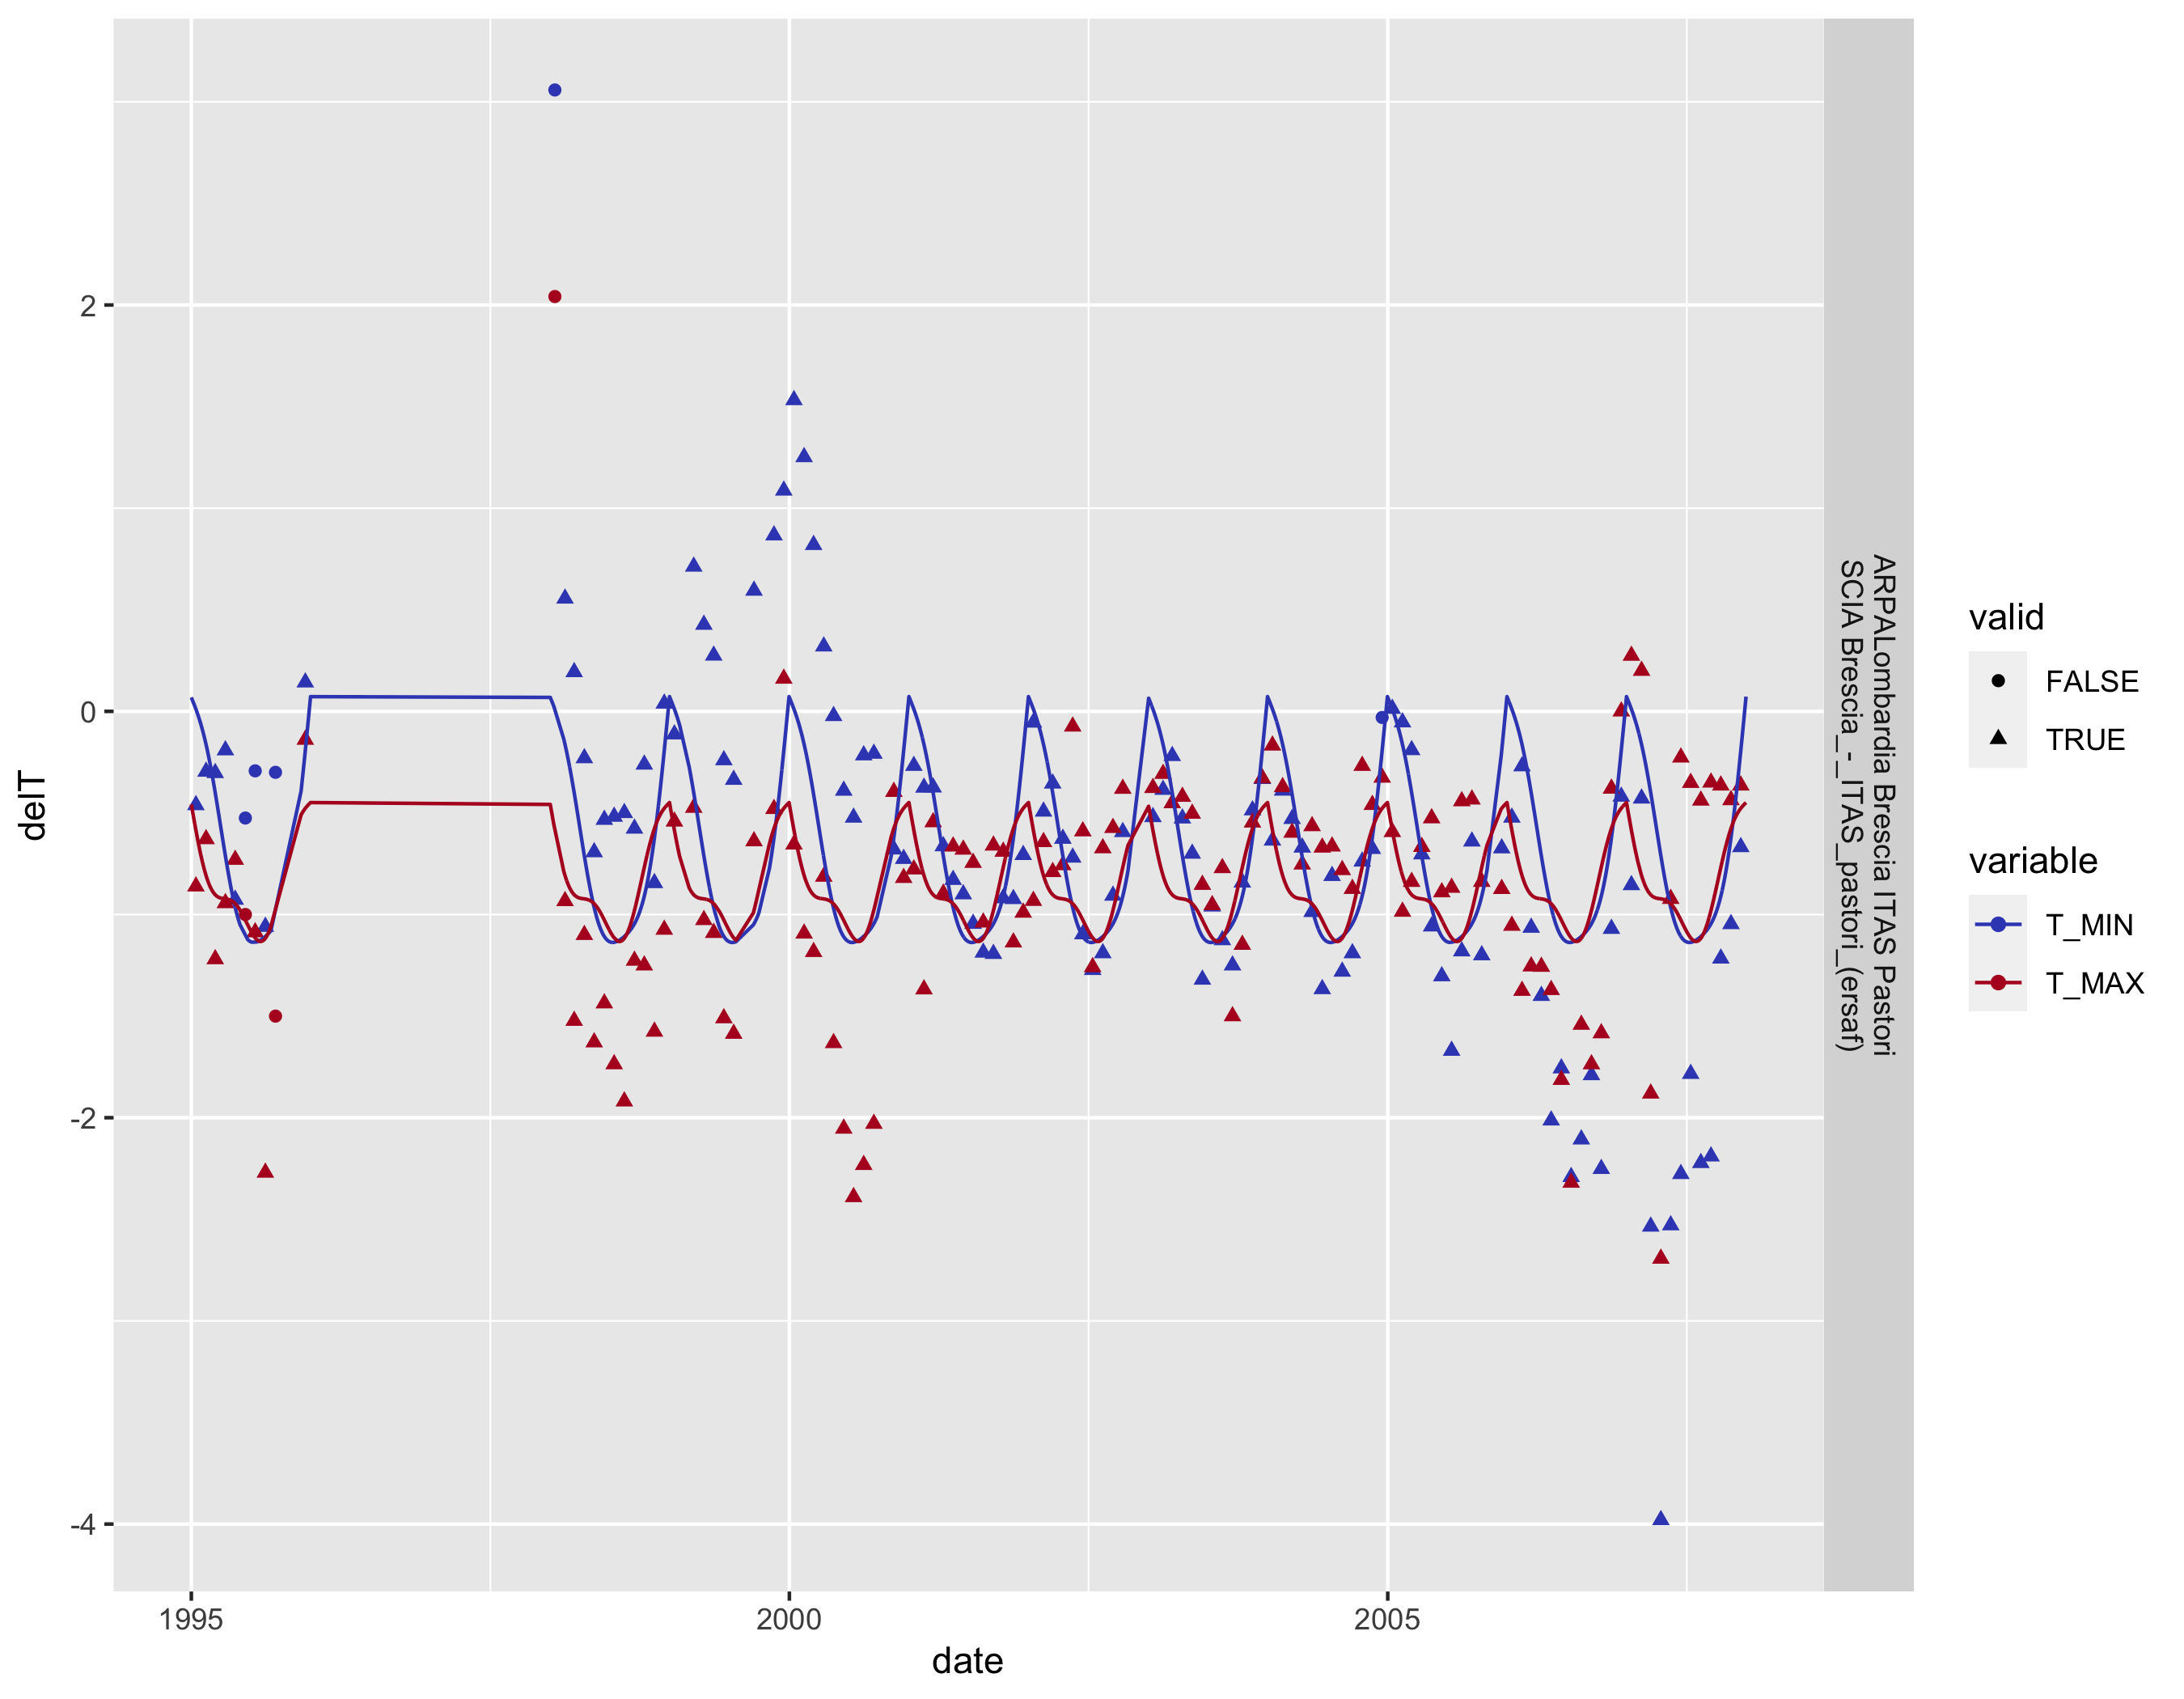

In [19]:
i |> filter(gkey == 24L) |> plot_correction(actual_metadata, actual_data)

In [18]:
merge_results <- dynamic_merge(actual_data, ranked_series_groups, actual_metadata, tagged_analysis, rejection_threshold = 10, ignore_corrections, contribution_threshold = 2L*365L)
merged_checkpoint(merge_results, actual_metadata, new_dataset, conns$stations)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2337142,124.9,3764034,201.1,NA,3764034,201.1
Vcells,38795479,296.0,130004775,991.9,16384,112661077,859.6


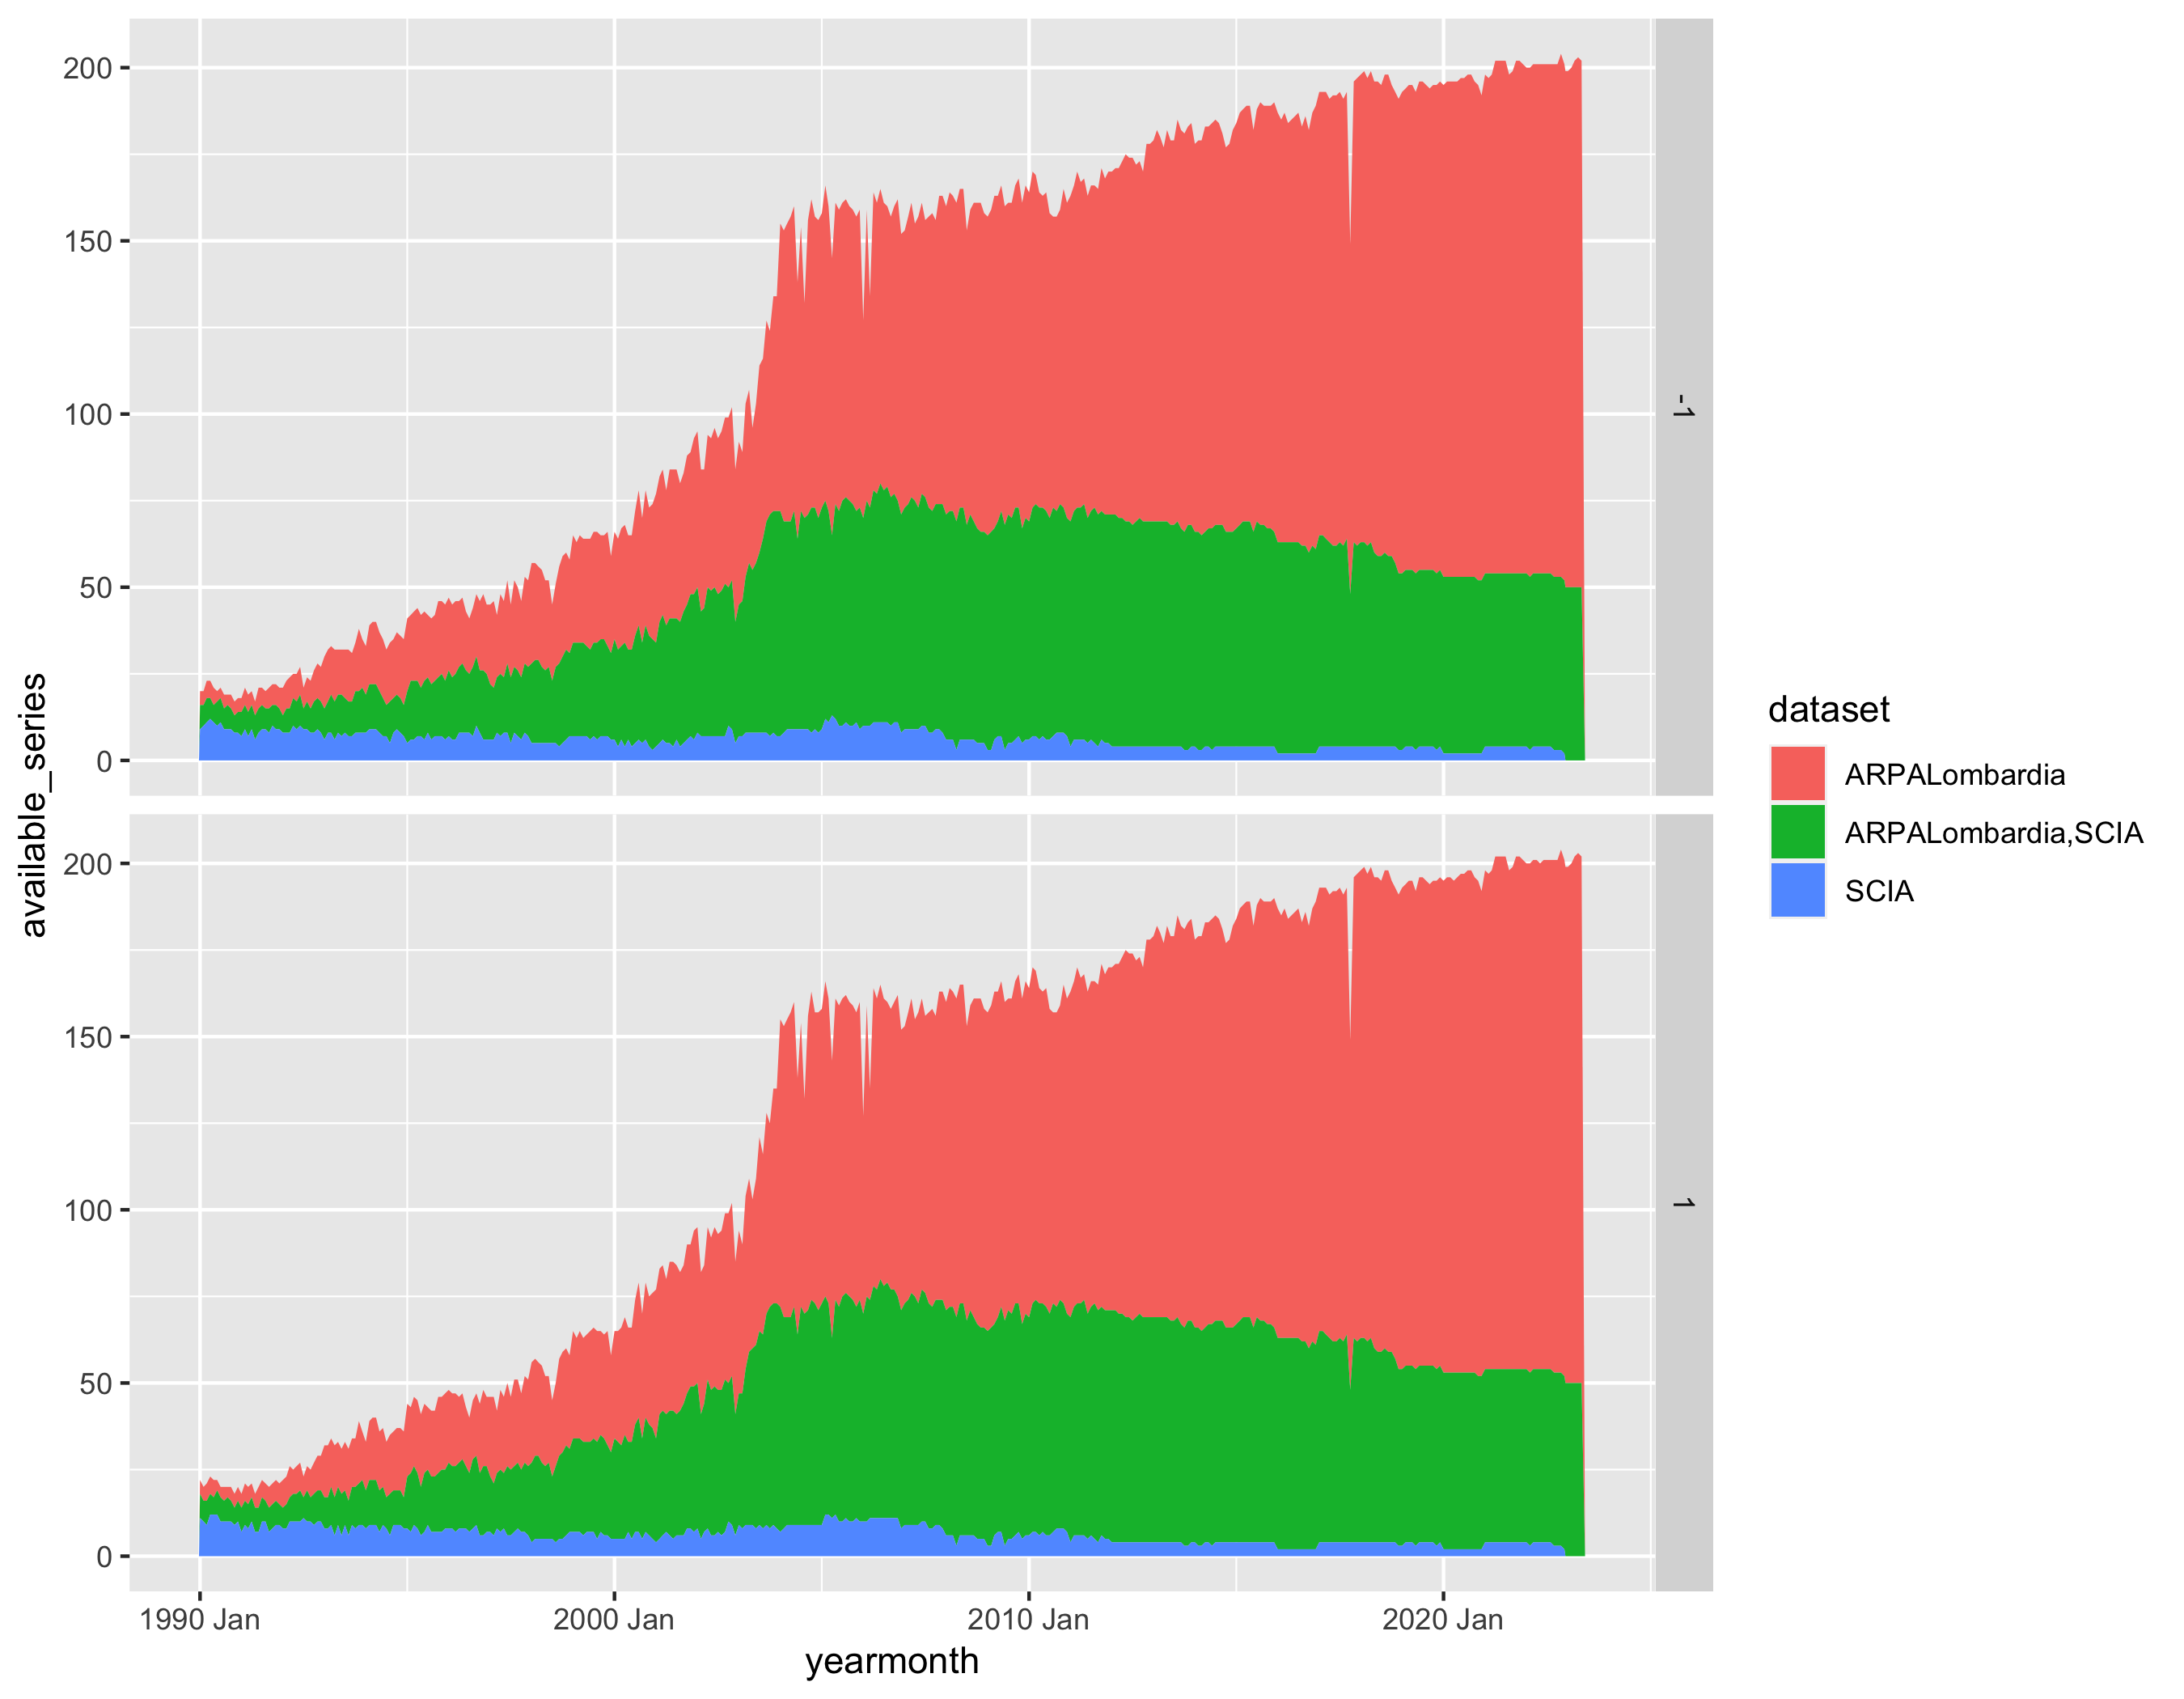

In [20]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


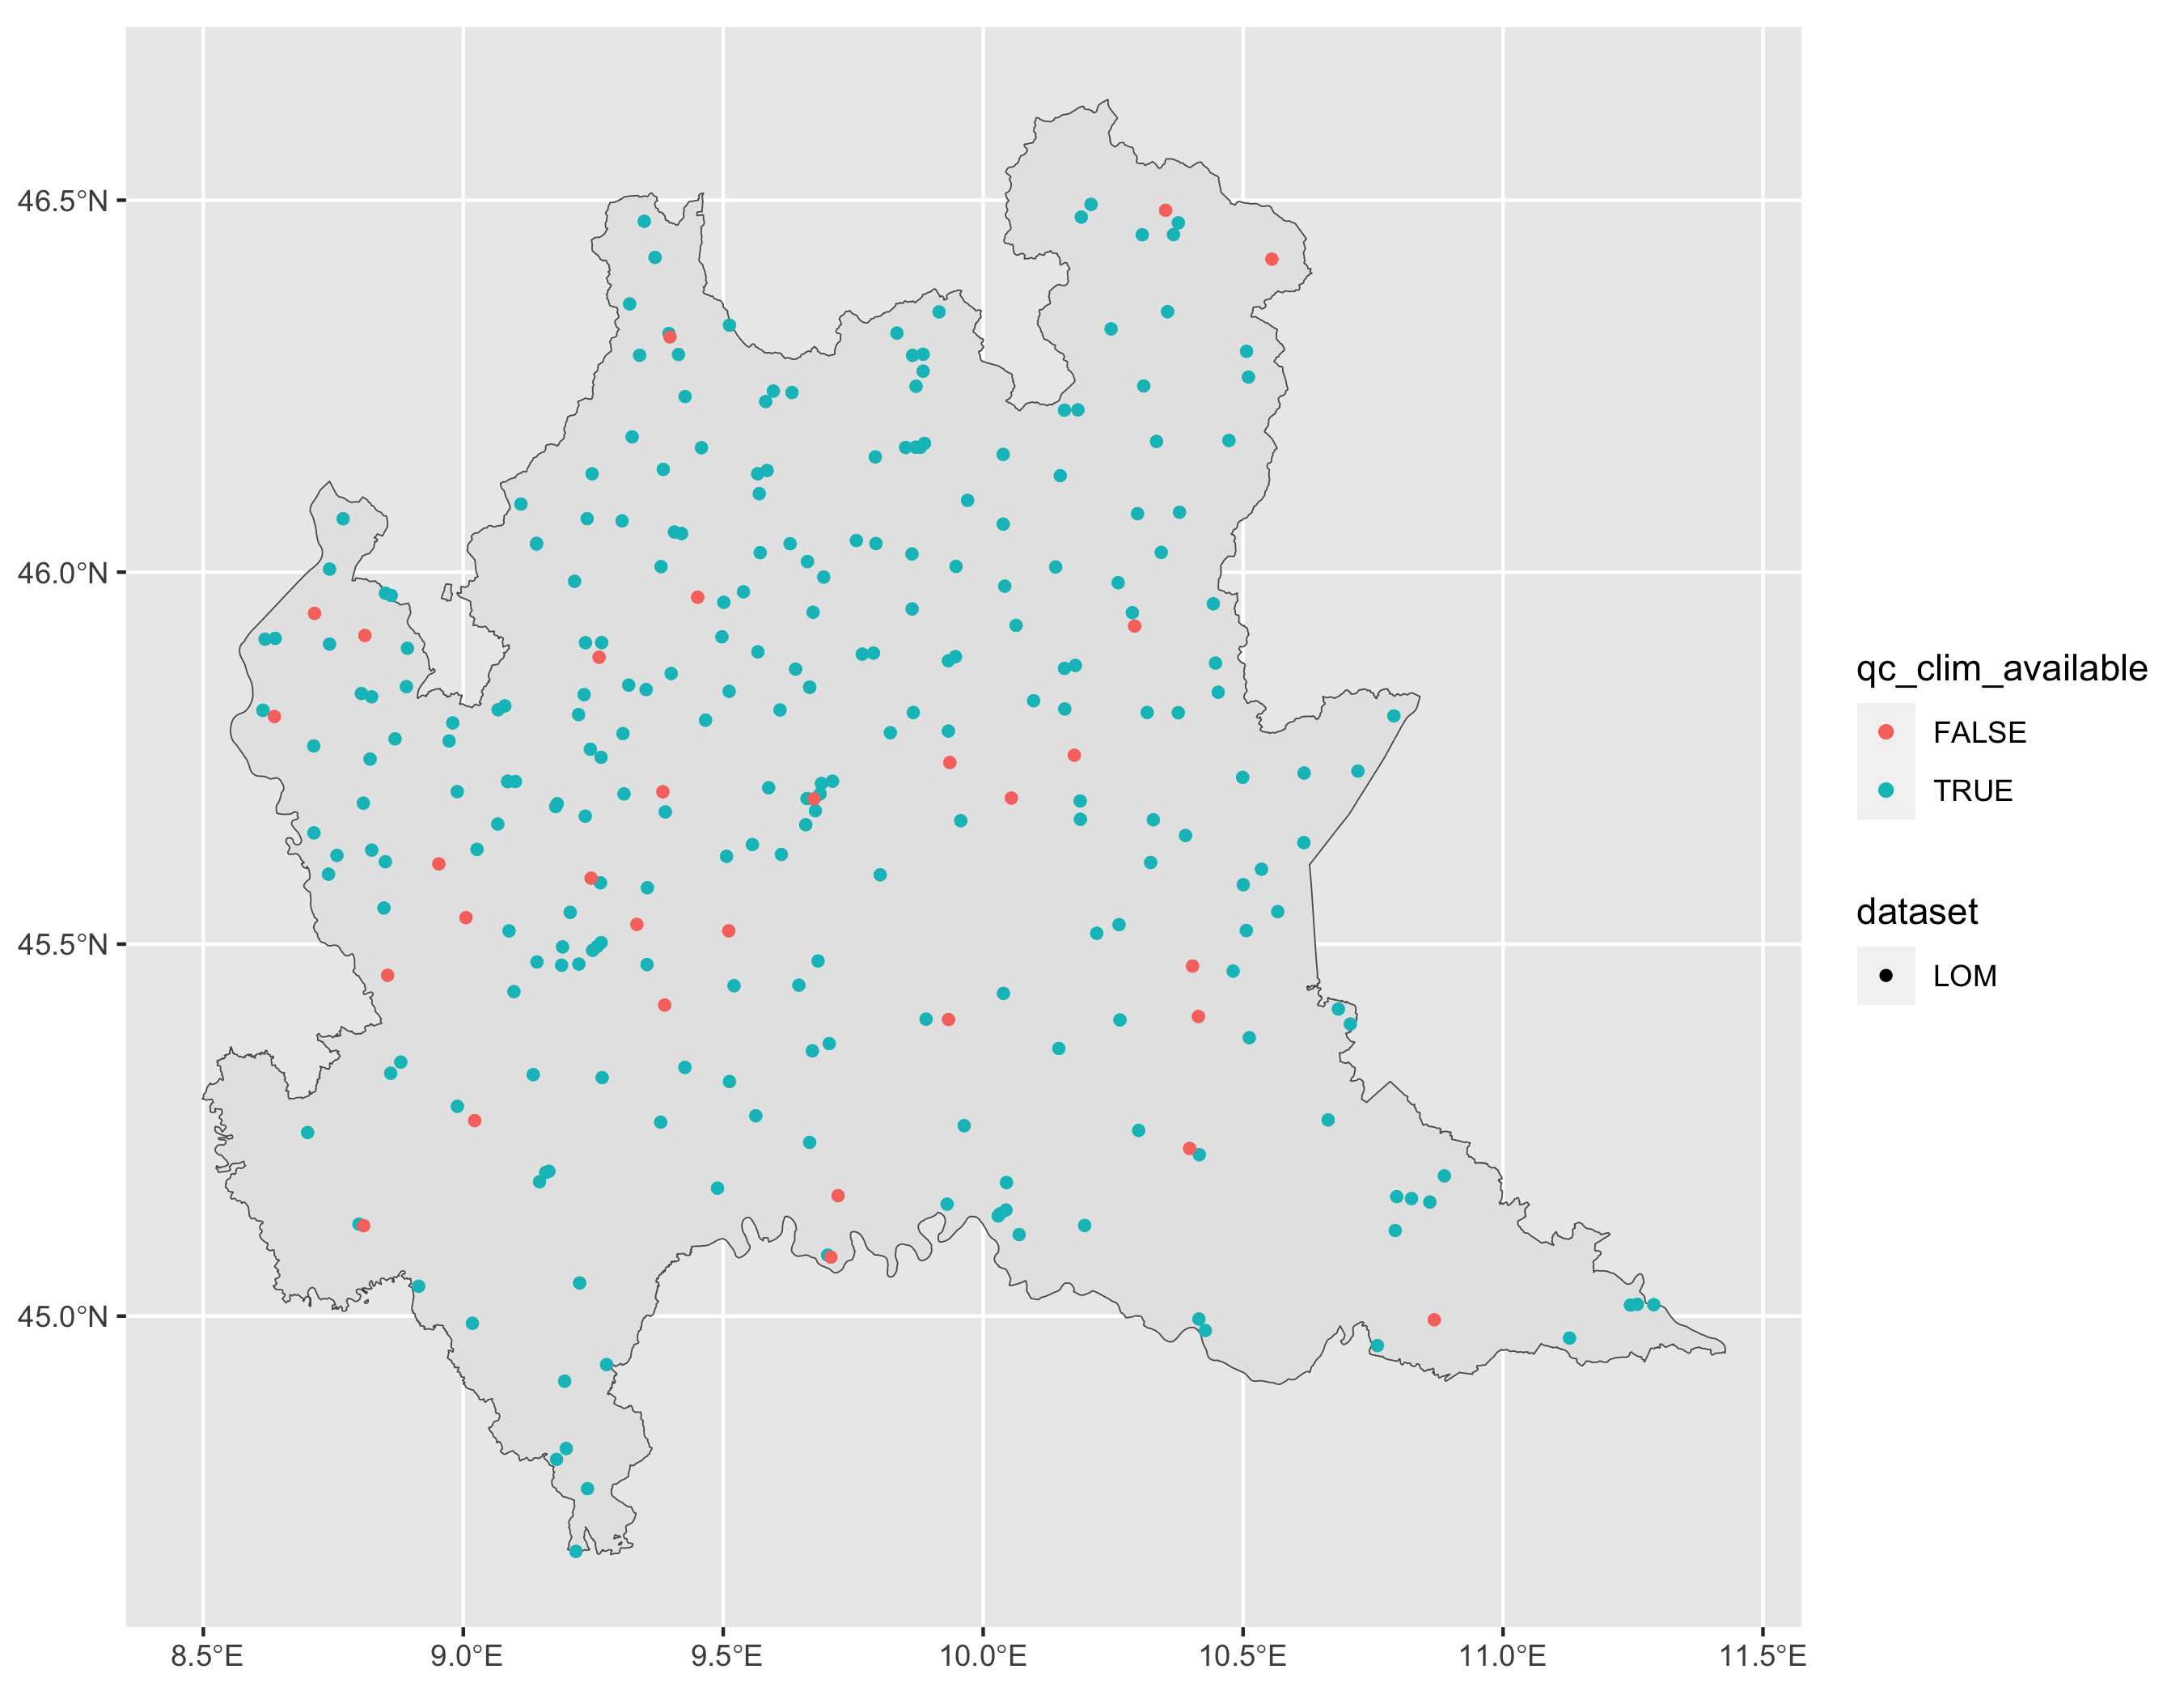

In [21]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot


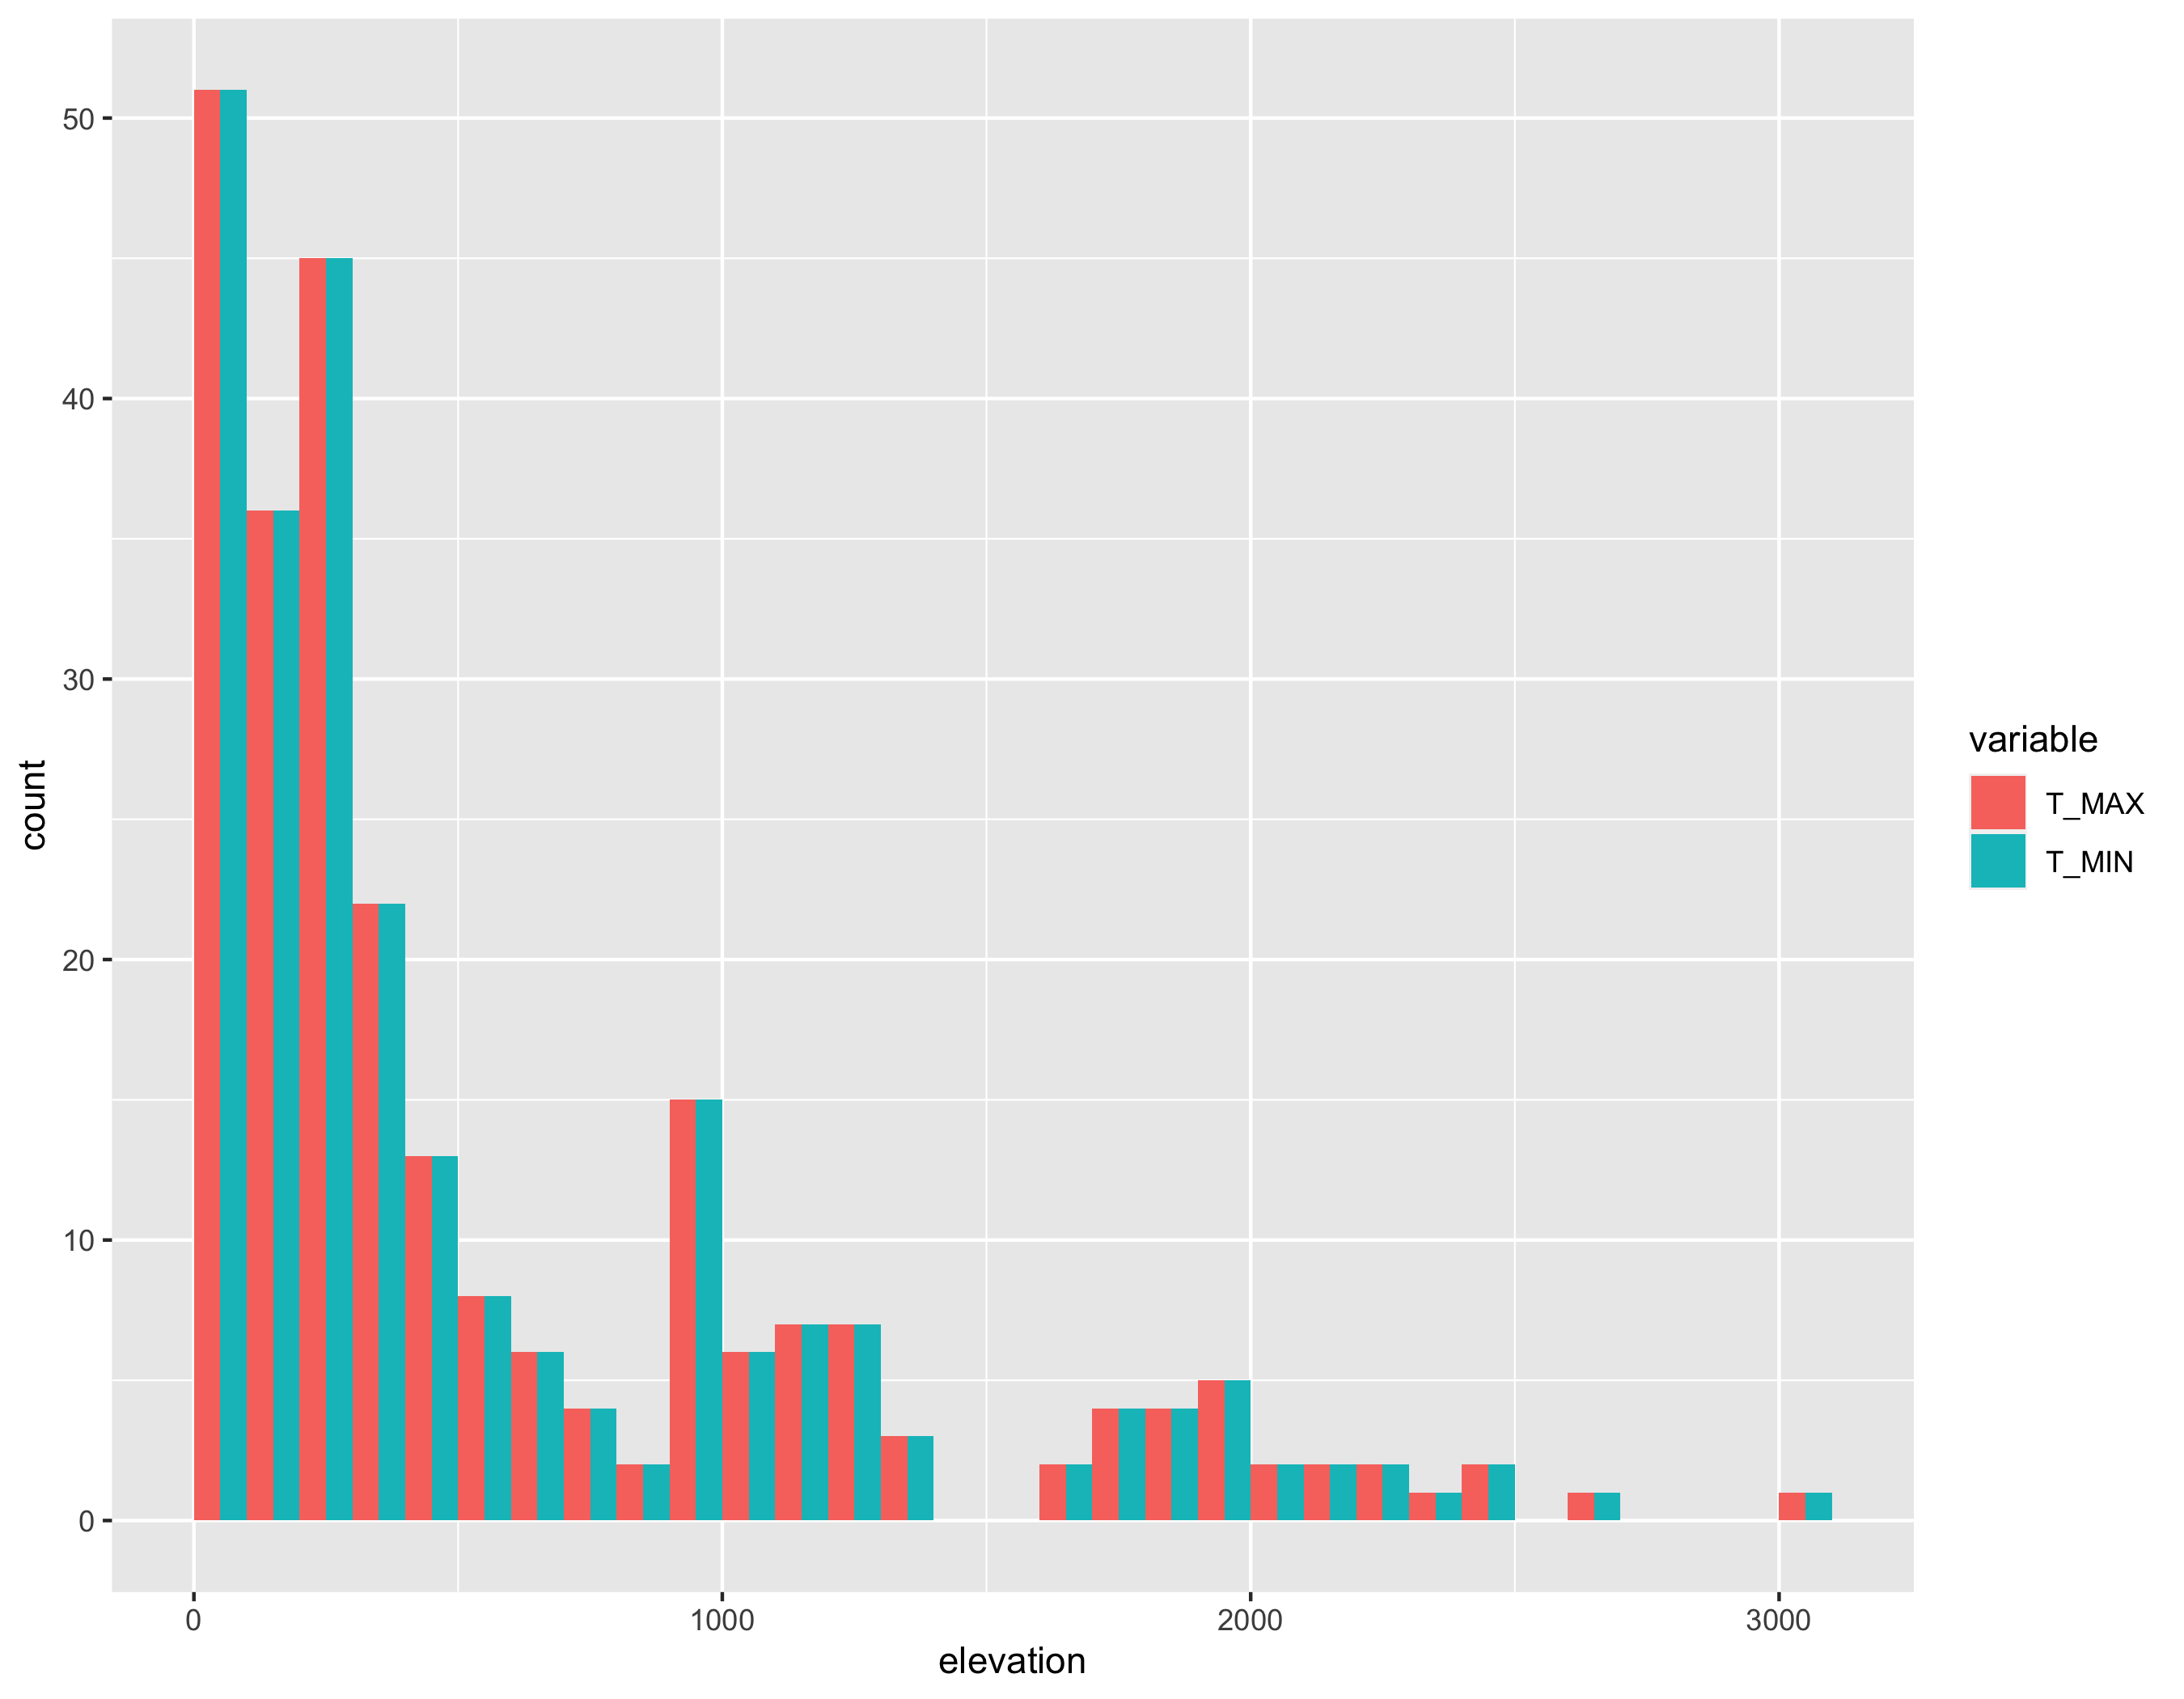

In [22]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [13]:
source("src/merging/display.R")
show_merge(db$meta, metadata_db, "network", "lon", "lat", "elevation", "sensor_first", "sensor_last") |>
    arrange(master_key) |>
    write.xlsx("lom.xlsx", asTable = TRUE)
